<a href="https://colab.research.google.com/github/zhangxuan1003/cheatsheet1/blob/master/Flow_over_cylinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [ ]:
!pip install pyDOE
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18167 sha256=9779e2bbc7302e3182224fa41294c98790324989869dc48a8aa0e9d8271fd38a
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print (device)

cuda


## Physics-informed Neural Networks

In [ ]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out[:,0],out[:,1]
        # return out

In [ ]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, dataloader, layers, lb, ub):
    # def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        # self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        # self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        # self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        # self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        # self.u = torch.tensor(u).float().to(device)
        # for X in dataloader:
        #####
        self.t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.x = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.y = torch.tensor(X[:, 2:3], requires_grad=True).float().to(device)
        self.p = torch.tensor(X[:, 3:4], requires_grad=True).float().to(device)
        self.u = torch.tensor(X[:, 4:5], requires_grad=True).float().to(device)
        self.v = torch.tensor(X[:, 5:6], requires_grad=True).float().to(device)      
        ######
        self.layers = layers
        # self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, t,x,y,p):  
        u,v = self.dnn(torch.cat([t,x,y,p], dim=1))
        return u,v
    
    def net_f(self,t,x,y,p):
        """ The pytorch autograd version of calculating residual """
        u,v = self.net_u(t,x,y,p)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        ### there is also du/dy and duy/dyterms here
        u_y = torch.autograd.grad(
            u, y, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_yy = torch.autograd.grad(
            u_y, y, 
            grad_outputs=torch.ones_like(u_y),
            retain_graph=True,
            create_graph=True
        )[0]        
        ## add v terms here
        v_t = torch.autograd.grad(
            v, t, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        v_y = torch.autograd.grad(
            v, y, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        v_yy = torch.autograd.grad(
            v_y, y, 
            grad_outputs=torch.ones_like(v_y),
            retain_graph=True,
            create_graph=True
        )[0] 
        ### there is also dv/dx term and dvx/dx
        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0] 
        v_xx = torch.autograd.grad(
            v_x, x, 
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True
        )[0]         
        ## also pressure term
        p_x = torch.autograd.grad(
            p, x, 
            grad_outputs=torch.ones_like(p),
            allow_unused=True,
            retain_graph=True,
            create_graph=True
        )[0]
        p_y = torch.autograd.grad(
            p, y, 
            grad_outputs=torch.ones_like(p),
            allow_unused=True,
            retain_graph=True,
            create_graph=True
        )[0]        
        f_u = (
            u_t
            + 1.0 * (u* u_x)
            + p_x
            - 0.01 * (u_xx + u_yy)
        )
        f_v = (
            v_t
            + 1.0 * (u* v_x + v * v_y)
            + p_y
            - 0.01 * (v_xx + v_yy)
        )
        return f_u,f_v
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred,v_pred = self.net_u(self.t,self.x,self.y,self.p)
        f_u_pred,f_v_pred = self.net_f(self.t,self.x,self.y,self.p)
        loss_u = torch.mean((self.u - u_pred) ** 2 + (self.v - v_pred) ** 2)
        loss_f = torch.mean(f_u_pred ** 2 + f_v_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        y = torch.tensor(X[:, 2:3], requires_grad=True).float().to(device)
        p = torch.tensor(X[:, 3:4], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(t,x,y,p)
        f= self.net_f(t,x,y,p)
        u,v = u.detach().cpu().numpy()
        f_u,f_v = f.detach().cpu().numpy()
        return u,v,f_u, f_v

## Configurations

In [ ]:
nu = 0.01

N_u = 660000
layers = [4, 64, 64, 64, 64, 64, 64, 64,2]

data = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/PINNs/Burgers Equation/data/cylinder_nektar_wake.mat')
X_star = data["X_star"]  # N x 2
x = X_star[:, 0:1]
y = X_star[:, 1:2]

U_star = data["U_star"]  # N x 2 x T
P_star = data["p_star"]  # N x T
t_star = data["t"]  # T x 1
# X_star = data["X_star"]  # N x 2
N = X_star.shape[0]
T = t_star.shape[0]
XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
TT = np.tile(t_star, (1, N)).T  # N x T
UU = U_star[:, 0, :]  # N x T
VV = U_star[:, 1, :]  # N x T
PP = P_star  # N x T
x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = UU.flatten()[:, None]  # NT x 1
v = VV.flatten()[:, None]  # NT x 1}
p = PP.flatten()[:, None]  # NT x 1
min_x = np.min(x)
max_x = np.max(x)
train_data = np.hstack((t, x, y, p, u, v))
lb = train_data.min(0)
ub = train_data.max(0) 

-0.624110517662326

In [ ]:

# nu = 0.01

# # N_u = 900
# layers = [4, 64, 64, 64, 64, 64, 64, 64,2]

# data = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/PINNs/Burgers Equation/data/data.mat')

# # t = data['t'].flatten()[:,None]
# # x = data['x'].flatten()[:,None]
# # Exact = np.real(data['usol']).T

# # X, T = np.meshgrid(x,t)

# # X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  # [X=-1:1, t=0],[X=-1:1, t=0.01],...[X=-1:1, t=0.99]
# # u_star = Exact.flatten()[:,None]              

# # # Doman bounds
# # lb = X_star.min(0)
# # ub = X_star.max(0) 
# X_star = data["X_star"]  # N x 2
# x = X_star[:, 0:1]
# y = X_star[:, 1:2]

# U_star = data["U_star"]  # N x 2 x T
# P_star = data["p_star"]  # N x T
# t_star = data["t"]  # T x 1
# X_star = data["X_star"]  # N x 2


# N = X_star.shape[0]
# T = t_star.shape[0]

# # Rearrange Data
# XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
# YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
# TT = np.tile(t_star, (1, N)).T  # N x T

# UU = U_star[:, 0, :]  # N x T
# VV = U_star[:, 1, :]  # N x T
# PP = P_star  # N x T

# x = XX.flatten()[:, None]  # NT x 1
# y = YY.flatten()[:, None]  # NT x 1
# t = TT.flatten()[:, None]  # NT x 1

# u = UU.flatten()[:, None]  # NT x 1
# v = VV.flatten()[:, None]  # NT x 1}
# # p = PP.flatten()[:, None]  # NT x 1
# p=1.0-x

# min_x = np.min(x)
# max_x = np.max(x)
# train_data = np.hstack((t, x, y, p, u, v))
# lb = train_data.min(0)
# ub = train_data.max(0) 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
training_loader = torch.utils.data.DataLoader(train_data, batch_size=4000, shuffle=True)

In [ ]:
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

## Training

In [ ]:
for X in training_loader:
  # print (X.shape)

torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size([4000, 6])
torch.Size

In [ ]:
%%time

noise = 0.0            
# create training set
idx = np.random.choice(training_loader, N_u, replace=True)
X_u_train = train_data[idx,:]
u_train = train_data[idx,:]

# training
model = PhysicsInformedNN(training_loader, layers, lb, ub)
model.train()

ValueError: ignored

Error u: 8.859424e-03


Text(0.5, 0, 'y')

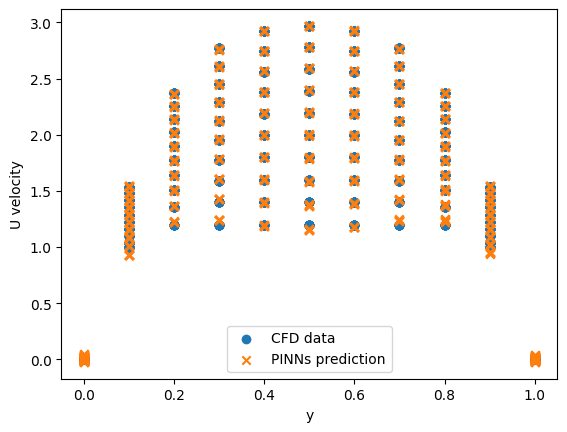

## Visualizations